Which traffic source leads to the highest number of purchases?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

In [3]:
df_events=pd.read_csv("df_events.csv")
df_events.head()

,creation_date,creation_time,user_id,city,state,browser,traffic_source,uri,event_type
0,2025-12-03,02:50:59,15774.0,Sapporo,Hokkaido,Chrome,Adwords,/department/women/category/dresses/brand/moonar,department
1,2021-05-25,05:21:06,86066.0,Lagastation,Akita,Safari,Email,/department/women/category/skirts/brand/blanks...,department
2,2025-05-04,06:50:00,NaN,São Paulo,São Paulo,Firefox,Facebook,/department/men/category/underwear/brand/inder...,department
3,2023-04-03,20:29:14,21853.0,São Paulo,São Paulo,Firefox,Facebook,/department/men/category/pants/brand/monologue,department
4,2019-07-16,12:02:00,NaN,São Paulo,São Paulo,Chrome,Email,/department/women/category/jeans/brand/guess,department


In [7]:
df_events["event_type"].unique()

<StringArray>
['department', 'home', 'product', 'purchase']
Length: 4, dtype: str

In [8]:
df_events_p=df_events[df_events["event_type"]=="purchase"]
df_events_p.head()


,creation_date,creation_time,user_id,city,state,browser,traffic_source,uri,event_type
840791,2024-09-03,07:52:09,66841.0,Sapporo,Hokkaido,Safari,Facebook,/purchase,purchase
840792,2021-09-12,09:38:43,39464.0,São Paulo,São Paulo,Chrome,Adwords,/purchase,purchase
840793,2026-02-15,07:21:30,19565.0,São Paulo,São Paulo,Chrome,Email,/purchase,purchase
840794,2024-10-17,11:52:23,5515.0,São Paulo,São Paulo,Chrome,Organic,/purchase,purchase
840795,2021-12-30,14:51:34,50285.0,São Paulo,São Paulo,Firefox,Adwords,/purchase,purchase


In [24]:
df_events_p['creation_date'] = pd.to_datetime(df_events_p['creation_date'])

Let's assume that purchase events correspond to the submission of a confirmed and payed order

In [25]:
df_events_p.groupby(["creation_date","traffic_source"])["event_type"].agg(['count'])

count
creation_date traffic_source       
2019-01-06    Adwords             1
2019-01-07    Adwords             1
2019-01-12    Email               2
2019-01-13    Adwords             1
2019-01-15    Email               1
...                             ...
2026-02-21    Facebook           30
              Organic             7
              YouTube            28
2026-02-22    Adwords             1
              Email               1

[11559 rows x 1 columns]

In [26]:
df_pivot = (
    df_events_p
        .pivot_table(
            index='creation_date',
            columns='traffic_source',
            values='event_type',
            aggfunc='count',
            fill_value=0
        )
        .reset_index()
)

df_pivot.head()

traffic_source,creation_date,Adwords,Email,Facebook,Organic,YouTube
0,2019-01-06,1,0,0,0,0
1,2019-01-07,1,0,0,0,0
2,2019-01-12,0,2,0,0,0
3,2019-01-13,1,0,0,0,0
4,2019-01-15,0,1,0,0,0


Do we have at least 1 not null value per year in each traffic source?

In [27]:
df_pivot['year'] = df_pivot['creation_date'].dt.year

In [28]:
df_pivot.head()

traffic_source,creation_date,Adwords,Email,Facebook,Organic,YouTube,year
0,2019-01-06,1,0,0,0,0,2019
1,2019-01-07,1,0,0,0,0,2019
2,2019-01-12,0,2,0,0,0,2019
3,2019-01-13,1,0,0,0,0,2019
4,2019-01-15,0,1,0,0,0,2019


In [31]:
df_pivot_year = (
    df_events_p
        .pivot_table(
            index=df_events_p['creation_date'].dt.year,
            columns='traffic_source',
            values='event_type',
            aggfunc='count',
            fill_value=0
        )
        .reset_index()
)

df_pivot_year.columns.name = None
df_pivot_year

,creation_date,Adwords,Email,Facebook,Organic,YouTube
0,2019,549,765,161,88,179
1,2020,1714,2634,570,313,601
2,2021,3211,4902,1109,498,1088
3,2022,5084,7591,1622,852,1674
4,2023,7373,11376,2571,1255,2517
5,2024,11104,16725,3651,1854,3714
6,2025,18907,28516,6286,3116,6342
7,2026,6502,9505,2122,1031,2118


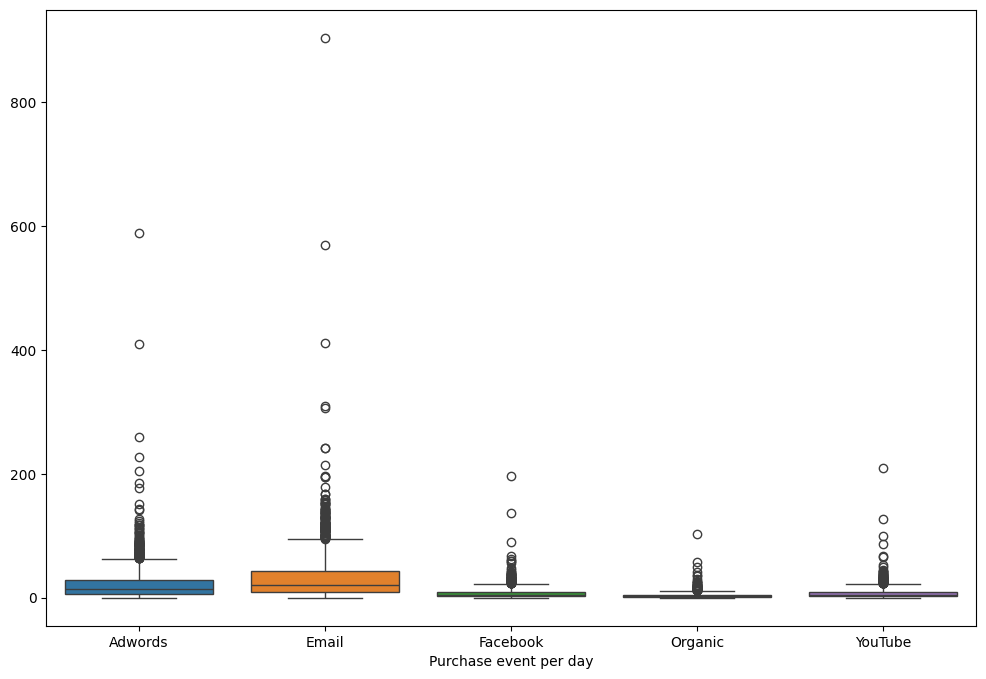

In [49]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_pivot[["Adwords", "Email", "Facebook", "Organic", "YouTube"]])
plt.xlabel("Purchase event per day");

In [20]:
df_pivot["Adwords"].describe()

count    2567.000000
mean       21.209194
std        25.929161
min         0.000000
25%         6.000000
50%        14.000000
75%        29.000000
max       589.000000
Name: Adwords, dtype: float64

In [32]:
df_pivot["Email"].describe()

count    2567.000000
mean       31.949357
std        38.312034
min         0.000000
25%         9.000000
50%        21.000000
75%        43.000000
max       904.000000
Name: Email, dtype: float64

In [35]:
adwords_list=df_pivot["Adwords"].tolist()
len(adwords_list)

2567

In [36]:
email_list=df_pivot["Email"].tolist()
len(adwords_list)

2567

In [51]:
mu_adwords = np.mean(adwords_list)
mu_email = np.mean(email_list)
mu_diff = mu_email-mu_adwords
print(mu_diff)

10.74016361511492


In [ ]:
#creazione della tabella per la permutazione, ottenuta collegando la lista adwords alla lista email
df_perm = pd.DataFrame({'source': ['adwords' if el <= len(adwords_list) else 'email' for el in range(1,(len(adwords_list)*2)+1)],
                   'purchase_per_day': adwords_list + email_list})
df_perm

,source,purchase_per_day
0,adwords,1
1,adwords,1
2,adwords,0
3,adwords,1
4,adwords,0
...,...,...
5129,email,309
5130,email,241
5131,email,196
5132,email,153


In [54]:
#creazione della lista di differenze tra le medie dei gruppi, su 2000 campionature
n = 2000
mu_diff_samples = []
for i in range(n): 
    values_sample1 = df_perm.sample(frac=0.5, replace=False)
    ix2 = set(df_perm.index) - set(values_sample1.index)
    values_sample2 = df_perm.iloc[list(ix2)]
    mu_diff_temp = np.mean(values_sample1['purchase_per_day']) - np.mean(values_sample2['purchase_per_day'])
    mu_diff_samples.append(mu_diff_temp)
mu_diff_samples

[np.float64(-0.9879236462797039),
 np.float64(-0.5936891312816535),
 np.float64(0.37943124269575534),
 np.float64(0.7027658745617451),
 np.float64(0.006232956758861263),
 np.float64(0.15504479937670368),
 np.float64(-0.31943903389170103),
 np.float64(-1.1390728476821188),
 np.float64(-0.8102843786521241),
 np.float64(0.9622126996493954),
 np.float64(0.7386053759252036),
 np.float64(0.28515777171795875),
 np.float64(0.690299961044019),
 np.float64(-0.3950136345929103),
 np.float64(0.7993767043241142),
 np.float64(-0.3435917413322933),
 np.float64(0.38644331904947293),
 np.float64(-1.0198675496688736),
 np.float64(0.6497857421114155),
 np.float64(0.7736657576938057),
 np.float64(1.1655629139072836),
 np.float64(0.11608881963381279),
 np.float64(-1.8745617452278935),
 np.float64(0.41293338527463774),
 np.float64(-0.3287884690299947),
 np.float64(-2.263342423061939),
 np.float64(-0.07401636151149305),
 np.float64(-0.779898714452667),
 np.float64(-0.380989481885468),
 np.float64(-0.35839501

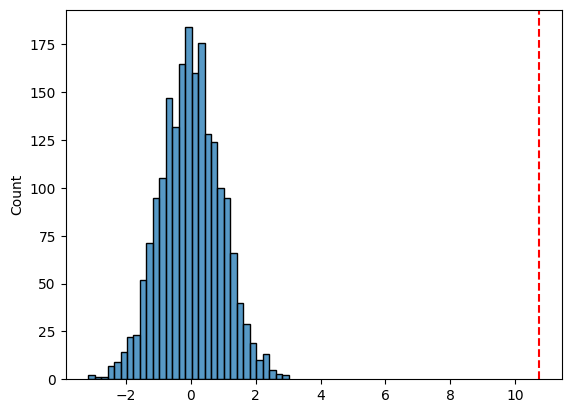

mu_diff: 10.74


In [55]:
sns.histplot(mu_diff_samples)
plt.axvline(mu_diff, 0, 1, color='r', linestyle='--')
plt.show()
print('mu_diff:', round(mu_diff, 2))

In [56]:
sum(mu_diff_samples>mu_diff)

np.int64(0)

In [57]:
p_value = sum(mu_diff_samples>mu_diff)/n
print('p-value: ', p_value)

p-value:  0.0


We can reject the null hypothesis: emails really lead to more purchases than AdWords.